In [12]:
from datasets import Dataset
import pandas as pd
import spacy
import stanza
import matplotlib.pyplot as plt
import numpy as np

# Loading Stanza models for Arabic
stanza.download('ar')

2024-05-01 14:48:29 INFO: Downloaded file to /Users/perrine/stanza_resources/resources.json
2024-05-01 14:48:29 INFO: Downloading default packages for language: ar (Arabic) ...
2024-05-01 14:48:29 INFO: File exists: /Users/perrine/stanza_resources/ar/default.zip
2024-05-01 14:48:31 INFO: Finished downloading models and saved to /Users/perrine/stanza_resources


In [7]:
data = pd.read_csv("../../data/csv/data.csv")

# Create a dataset from the pandas dataframe
dataset = Dataset.from_pandas(data)
dataset

Dataset({
    features: ['Label', 'Text'],
    num_rows: 2620
})

In [8]:
# Morpho-syntaxical annotation

# Tokenizers
# Loading SpaCy models
nlp_en = spacy.load("en_core_web_sm")  # English
nlp_es = spacy.load("es_core_news_sm")  # Spanish
nlp_de = spacy.load("de_core_news_sm")  # German
nlp_fr = spacy.load("fr_core_news_sm")  # French
nlp_ru = spacy.load("ru_core_news_sm")  # Russian
nlp_zh = spacy.load("zh_core_web_sm")  # Chinese
nlp_ja = spacy.load("ja_core_news_sm")  # Japanese
nlp_ko = spacy.load("ko_core_news_sm")  # Korean

# Loading StanfordNLP models
nlp_ar = stanza.Pipeline(lang='ar')

def tokenize_and_annotate(text: str, lang: str) -> list:
    """
    Tokenize et annote morpho-syntaxiquement un texte dans une langue donnée.

    Parameters:
    text (str): le texte à tokeniser et annoter.
    lang (str): la langue du texte.

    Returns:
    list: une liste de tuples (token, POS) pour chaque token du texte.
    """
    if lang == 'ar':
        doc = nlp_ar(text)
        return [(word.text, word.upos) for sent in doc.sentences for word in sent.words]
    else:
        nlp = globals()[f"nlp_{lang}"]
        doc = nlp(text)
        return [(token.text, token.pos_) for token in doc]
    

2024-05-01 14:47:52 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-05-01 14:47:52 INFO: Downloaded file to /Users/perrine/stanza_resources/resources.json
2024-05-01 14:47:53 INFO: Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |
| depparse  | padt_charlm   |
| ner       | aqmar_charlm  |

2024-05-01 14:47:53 INFO: Using device: cpu
2024-05-01 14:47:53 INFO: Loading: tokenize
2024-05-01 14:47:53 INFO: Loading: mwt
2024-05-01 14:47:53 INFO: Loading: pos
2024-05-01 14:47:53 INFO: Loading: lemma
2024-05-01 14:47:53 INFO: Loading: depparse
2024-05-01 14:47:53 INFO: Loading: ner
2024-05-01 14:47:54 INFO: Done loading processors!


In [9]:
# Number of each entity type per language
def count_entities(dataset: list) -> dict:
    """
    Compte le nombre d'entités de chaque type par langue dans un dataset.

    Parameters:
    dataset (list): le dataset à analyser.

    Returns:
    dict: un dictionnaire dont les clés sont les types d'entités et les valeurs sont des dictionnaires
          dont les clés sont les langues et les valeurs sont les nombres d'entités de ce type dans cette langue.
    """
    entities = {}
    for sentence in dataset:
        text = sentence['Text']
        lang = sentence['Label']
        sentence['tokens_pos'] = tokenize_and_annotate(text, lang)
        for token, pos in sentence['tokens_pos']:
            if pos not in entities:
                entities[pos] = {}
            if lang not in entities[pos]:
                entities[pos][lang] = 0
            entities[pos][lang] += 1
    
    sorted_entities = {pos: dict(sorted(lang_counts.items(), key=lambda item: item[1], reverse=True))
                       for pos, lang_counts in sorted(entities.items(), key=lambda x: x[0])}

    return sorted_entities



In [10]:
entities = count_entities(dataset)
entities

{'ADJ': {'en': 2015,
  'ru': 1762,
  'fr': 1629,
  'es': 566,
  'de': 559,
  'zh': 221,
  'ar': 156,
  'ja': 113,
  'ko': 98},
 'ADP': {'fr': 4107,
  'en': 3470,
  'ja': 2431,
  'ru': 2006,
  'es': 1308,
  'de': 1284,
  'zh': 379,
  'ar': 220,
  'ko': 66},
 'ADV': {'fr': 990,
  'en': 892,
  'ru': 709,
  'zh': 640,
  'de': 612,
  'ko': 411,
  'es': 185,
  'ja': 75,
  'ar': 3},
 'AUX': {'en': 1122,
  'ja': 1061,
  'fr': 693,
  'de': 373,
  'es': 221,
  'ru': 220,
  'ko': 83,
  'ar': 7},
 'CCONJ': {'en': 988,
  'ru': 732,
  'fr': 622,
  'de': 316,
  'es': 260,
  'ko': 223,
  'zh': 180,
  'ar': 116,
  'ja': 46},
 'DET': {'fr': 3257,
  'en': 2401,
  'de': 1111,
  'es': 914,
  'ru': 535,
  'zh': 101,
  'ja': 54,
  'ko': 35,
  'ar': 20},
 'INTJ': {'ru': 5, 'en': 3, 'fr': 1, 'zh': 1},
 'NOUN': {'fr': 5264,
  'en': 5163,
  'ru': 4984,
  'ja': 4288,
  'zh': 2528,
  'de': 2105,
  'es': 1386,
  'ko': 1238,
  'ar': 440},
 'NUM': {'zh': 424,
  'ru': 189,
  'en': 186,
  'fr': 141,
  'ja': 65,
  'de':

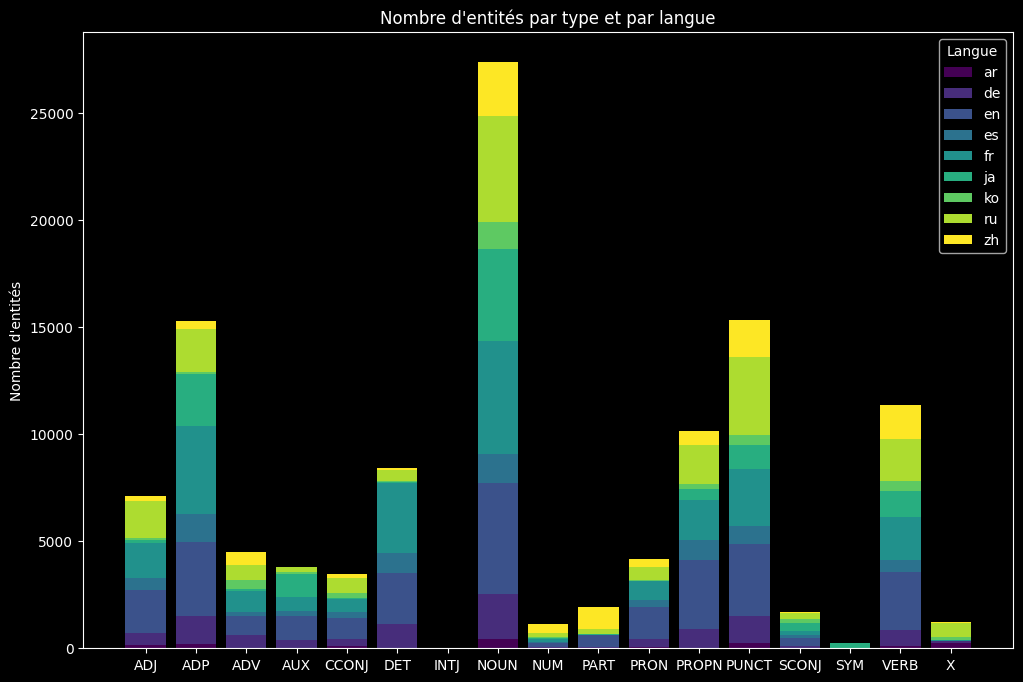

In [13]:
def plot_entity_distribution(data: dict) -> None:
    """
    Trace un graphique en barres empilées des entités par langue pour chaque type d'entité.

    Parameters:
    data (dict): Dictionnaire des entités triées retourné par la fonction count_entities.

    Returns:
    None
    """
    # Préparation des données pour le tracé
    languages = set()
    for entities in data.values():
        languages.update(entities.keys())
    languages = sorted(languages)

    # Création de données pour le tracé
    labels = list(data.keys())
    bottom = [0] * len(labels)
    colors = plt.cm.viridis(np.linspace(0, 1, len(languages)))
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for idx, lang in enumerate(languages):
        counts = [data[pos].get(lang, 0) for pos in labels]
        ax.bar(labels, counts, bottom=bottom, color=colors[idx], label=lang)
        bottom = [i + j for i, j in zip(bottom, counts)]
    
    ax.set_ylabel('Nombre d\'entités')
    ax.set_title('Nombre d\'entités par type et par langue')
    ax.legend(title='Langue')

    plt.show()

plot_entity_distribution(entities)

1. **Répartition par Langue** :
   - Je remarque que le français, l'anglais et le russe sont très présents dans presque toutes les catégories d'entités, ce qui suggère que mon corpus est probablement dominé par ces langues. Cela pourrait influencer les performances du modèle.
   - Le japonais et le chinois semblent aussi avoir des représentations significatives mais dans des catégories spécifiques, ce qui peut indiquer des particularités linguistiques propres à ces langues qui sont reflétées dans les données.

2. **Types d'Entités** :
   - Dans la catégorie des noms (`NOUN`), je vois que le français est en tête, suivi de près par l'anglais et le russe. Cela peut refléter non seulement une abondance de texte dans ces langues mais aussi une prédisposition à utiliser des noms fréquemment dans ces langues.
   - Pour les adpositions (`ADP`), le français est particulièrement prédominant, ce qui pourrait suggérer une structure grammaticale en français qui favorise ou nécessite l'utilisation fréquente de prépositions.
   - La ponctuation (`PUNCT`) est dominée par le russe, ce qui pourrait pointer vers des styles d'écriture spécifiques ou des différences dans l'annotation de la ponctuation en russe par rapport à d'autres langues.

3. **Représentation des Langues Moins Courantes** :
   - Les données pour le coréen, l'arabe et d'autres langues plus petites montrent des chiffres plus bas, ce qui me fait penser qu'elles sont sous-représentées dans mon corpus. Cela pourrait être dû au fait que les textes dans ces langues sont moins long.

Ces observations me donnent un aperçu précieux des dynamiques de mon corpus.